In [1]:
import numpy as np
from datetime import datetime
import random

import importlib
import os
import shutil
import sys
import torch
import torch.nn as nn, torch.optim as optim
from torch.distributions.categorical import Categorical

# import own modules
# ----------------------------------------------------------------------------
import torch_functions as tofu
import plot_functions as pf
import market_functions as mf
from util import timediff_d_h_m_s
import FinMa


importlib.reload(sys.modules["FinMa"])
importlib.reload(FinMa)
importlib.reload(pf)
importlib.reload(mf)
importlib.reload(tofu)

from FinMa import FinMa, BSassets

In [2]:
import config_2.config as config

mp = config.MARKET_PARAMS
a2cp = config.A2C_PARAMS
a2ctp = config.A2C_TRAIN_PARAMS
seed = config.SEED

if config.EVAL_PARAMS['use_wandb']:
    import wandb
    wandb.init(project=f"PPO_A2C_{config.CONFIG_NO}", config={'npath':a2cp['npath'],'seed':seed}, reinit=True)
    wandb.config.update(a2cp)
    wandb.config.update(a2ctp)
    wandb.config.update(mp)

In [3]:
# 1. Set `python` pseudo-random generator at a fixed value
random.seed(seed)

# 2. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)

# 3. Set 'torch' pseudo-random generator at a fixed value
torch.manual_seed(seed)

### 1. Market environment

In [4]:
interest = mp["interest"]
npath = a2cp["npath"]
ntime = mp["ntime"]
x0 = mp["x0"]
gamma = np.exp(-interest / ntime)

d = mp["d"]
s0 = [1 for i in range(d)]
mu = [0 for i in range(d)]
sig = mp["sig"]
cor = mp["cor"]
stds = np.sqrt(sig * np.eye(d))
Sigma = (stds @ cor @ stds).tolist()  # covariance structure of BM

weights = a2ctp['weights']

additional_states = None
num_states = d + 2

# additional states besides time, asset and portfolio value
if 'additional_states' in mp.keys():
    if mp['additional_states'] is not None:
        additional_states = mp['additional_states']
        l = len(additional_states)
        if 'signX' in additional_states:
            num_states += 1
            l -= 1
        num_states += l*d

# additional tasks besides maximizing reward
additional_tasks = None
if 'additional_tasks' in mp.keys():
    additional_tasks = mp['additional_tasks']

# connected network architecture for actor and critic
MTnetwork = False
if 'MTnetwork' in a2cp.keys():
    MTnetwork = a2cp['MTnetwork']

# number of steps until new initial state is sampled
nsteps_newPV = None
nsteps_newS = None
if 'nsteps_newPV' in a2ctp.keys():
    nsteps_newPV = a2ctp['nsteps_newPV']
if 'nsteps_newS' in a2ctp.keys():
    nsteps_newS = a2ctp['nsteps_newS']

In [5]:
if config.SAVE["model"]:
    foldername = os.path.join(
        f"config_{config.CONFIG_NO}",
        f"A2C_" + datetime.now().strftime("%d-%m-%Y_%H:%M") + "/",
    )
    path = os.path.join(
        os.getcwd(),
        foldername,
    )
    os.makedirs(path)
        
    configpath = os.path.join(
        os.getcwd(),
        f"config_{config.CONFIG_NO}",
        'config.py',
    )
    shutil.copyfile(configpath, os.path.join(path,'config.py'))
elif config.SAVE["plots"] and config.SAVE["plot_path"] is None:
    print("Error: Please supply path to save plots in config file.")
    exit()

### 2. Set up ACTOR & CRITIC

In [6]:
# set regularization parameter and learning rates
actor_lr = a2ctp["actor_lr"]
critic_lr = a2ctp["critic_lr"]
tau = a2ctp["tau"]
weight_decay = a2ctp["weight_decay"]


# initiate both nets
if MTnetwork:
    mt_a2c = tofu.Multitask_A2C_Net(dim=d,num_action=2*d,
        num_state=num_states, add_tasks=additional_tasks)
    actor = mt_a2c.actor
    critic = mt_a2c.critic
    MT_opt = optim.Adam(mt_a2c.parameters(), lr=critic_lr, weight_decay=weight_decay)
    
else:
    if additional_tasks is not None:
        actor = tofu.Multitask_Actor_Net(dim=d,num_action=2*d,
        num_state=num_states, add_tasks=additional_tasks)
        num_outputs = 2 * d + actor.num_add_tasks
    else:
        num_outputs = 2*d
        actor = tofu.Actor_Net(num_states, num_outputs)
        
    critic = tofu.Critic_Net(num_states)

    # in general, the algorithm is very sensitive to learning rates
    actor_opt = optim.Adam(actor.parameters(), lr=actor_lr, weight_decay=weight_decay)
    critic_opt = optim.Adam(critic.parameters(), lr=critic_lr, weight_decay=weight_decay)



### 3. Initiate Market Environment

terminal state: [[ 1.         -0.05941975  1.45083817  0.56167278]]


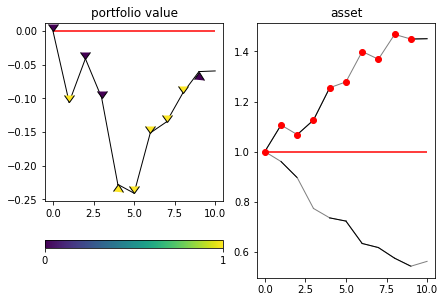

In [7]:
# %% EXAMPLE
asset = BSassets(
    interest=interest, s0=s0, sigma=Sigma, mu=mu, dim=d, ntime=ntime, npath=1
)
market = FinMa(
    pv0=x0,
    ntime=ntime,
    interest=interest,
    dim=d,
    npath=1,
    asset_model=asset,
    weights=weights,
    additional_states=additional_states,
)



#plot some steps of the game (very basic implementation)
market.trade_with_agent(actor, npath=1, foldername=foldername)
print(f'terminal state: {market.state}')
market.reset()


In [8]:
asset_env = BSassets(
    interest=interest,
    s0=s0,
    sigma=Sigma,
    mu=mu,
    dim=d,
    ntime=ntime,
    npath=npath,
)

In [9]:
market_env = FinMa(
    pv0=x0,
    ntime=ntime,
    interest=interest,
    dim=d,
    npath=npath,
    asset_model=asset_env,
    weights=weights,
    additional_states=additional_states,
)

### 4. A2C - Training

In [10]:
max_iter = a2ctp["max_iter"]
episode_len = ntime
total_reward = []
max_reward = torch.zeros((1,))

In [11]:
nis = False
nipv = False

In [12]:
start = datetime.now()


for num_iter in range(max_iter):
    # at each iteration, we roll out an episode using current policy until it reach termination state
    reward = []
    log_pi = []
    critics = []
    entropy = 0
    add_task_preds = []
    add_task_targets = []
    if num_iter % 10000 == 0:
        print(f"iteration {num_iter}\n")

    if nsteps_newS is not None:
        nis = (num_iter % nsteps_newS == 0)

    if nsteps_newPV is not None:
        nipv = (num_iter % nsteps_newPV == 0)
    
    market_env.reset(new_initial_pv=nipv, new_initial_stock=nis)
    
    #market_env.reset()
    s = market_env.state
    for t in range(episode_len):
        # given current state, the actor outputs two values as probability for each action
        state = torch.tensor(s, dtype=torch.float)
        pred = actor(state)
        prob = pred[:,:2*d]

        # track additional tasks
        if additional_tasks is not None:
            add_task_preds.append(pred[:,2*d:])
            add_task_targets.append(actor.create_add_task_targets(X=state[:,[1]],
            market_env=market_env))

        # create the distribution as current policy
        
        pi = Categorical(prob)
        # sample one action from this policy
        a = pi.sample()

        # interact with the environment
        action = np.array([market_env.poss_action[x] for x in a])

        (s, r, is_terminal,) = market_env.step(
            action.reshape((npath, 1, d)),
            log_type=2,
            keep_env_pathdim=True,
        )
        reward.append(r)

        # append log. prob. of action and value of critic at state
        log_pi.append(pi.log_prob(a))
        critics.append(critic(state))

        # track entropy estimate
        entropy += -torch.sum(pi.probs * torch.log(pi.probs), axis=-1) * gamma ** t

        # the loop is never broken for the PPO with terminal payoff only. however it might be needed for different payoff structures
        if is_terminal:
            break
    # append state at T+1
    state = torch.tensor(s, dtype=torch.float)
    critics.append(critic(state))

    # store total_reward
    discounted_rew = [reward[i] * gamma ** i for i in range(len(reward))]
    total_reward.append(np.mean(sum(discounted_rew)))

    
    avg_rew = np.mean(total_reward)
    if avg_rew>max_reward:
        max_reward = avg_rew
        save_dict = {
            'epoch': num_iter
        }
        if MTnetwork:
            save_dict['MT_opt'] = MT_opt.state_dict()
        else:
            save_dict['actor_optimizer_state_dict'] =actor_opt.state_dict()
            save_dict['critic_optimizer_state_dict'] = critic_opt.state_dict()
        torch.save(save_dict, path + 'details_best')
        torch.save(actor.state_dict(), path + "actor_best")
        torch.save(critic.state_dict(), path + "critic_best")
    
    # advantage estimate as sum over remaining discounted rewards - current value function estimate
    advantage = torch.stack(
        [
            torch.tensor(sum(discounted_rew[i:]) * gamma ** (-i)).view(-1, 1)
            - critics[i]
            for i in range(len(reward))
        ]
    )
    # losses
    actor_loss = -torch.mean(torch.sum(
        torch.stack(log_pi).view(ntime, npath, 1) * advantage.detach(), axis=0)
    ) - tau * torch.mean(entropy)
    critic_loss = torch.mean(torch.square(advantage))

    if config.EVAL_PARAMS['use_wandb']:
        logging_dict = {'actor_loss': actor_loss,
        'critic_loss': critic_loss,
        'advantage': torch.mean(advantage),
        'entropy': torch.mean(entropy),
        'total_reward': total_reward[-1],
        'running average reward': avg_rew}
        if num_iter>500:
            logging_dict['running average reward 500']= np.mean(total_reward[-500:])

    # additional tasks
    if additional_tasks is not None:
        add_task_preds = torch.stack(add_task_preds, dim=0)
        add_task_targets = torch.stack(add_task_targets, dim=0)
        add_task_loss = actor.loss_fn_A2C(add_task_preds, add_task_targets)/ntime
        actor_loss = actor_loss + add_task_loss
        if config.EVAL_PARAMS['use_wandb']:
            logging_dict['add_task_loss'] = add_task_loss
            logging_dict['total_actor_loss'] = actor_loss
    


    if MTnetwork:
        MT_opt.zero_grad()
        joint_loss = critic_loss+actor_loss
        joint_loss.backward()
        MT_opt.step()
    else:
        #actor_loss.retain_grad()       
        actor_opt.zero_grad()
        critic_opt.zero_grad()
        
        actor_loss.backward()
        critic_loss.backward()

        actor_opt.step() 
        critic_opt.step()    

    if config.EVAL_PARAMS['use_wandb']:
        wandb.log(logging_dict)

# take time after training
end = datetime.now()
print(
    "\nTraining Time: {}d {}h:{}m:{}s".format(*timediff_d_h_m_s(end - start)),
    "(" + datetime.now().strftime("%H:%M %d-%m-%Y") + ")",
)

iteration 0

iteration 10000

iteration 20000

iteration 30000

iteration 40000

iteration 50000

iteration 60000

iteration 70000

iteration 80000

iteration 90000

iteration 100000

iteration 110000

iteration 120000

iteration 130000

iteration 140000

iteration 150000

iteration 160000

iteration 170000

iteration 180000

iteration 190000

iteration 200000

iteration 210000

iteration 220000

iteration 230000

iteration 240000

iteration 250000

iteration 260000

iteration 270000

iteration 280000

iteration 290000

iteration 300000

iteration 310000

iteration 320000

iteration 330000

iteration 340000

iteration 350000

iteration 360000

iteration 370000

iteration 380000

iteration 390000


Training Time: 0d 4h:53m:58s (21:55 17-01-2023)


In [13]:
if config.SAVE["model"]:
    torch.save(actor.state_dict(), path + "actor")
    torch.save(critic.state_dict(), path + "critic")

### 5. Testing and visualizing

In [14]:
save = config.SAVE["plots"]

#### 1d & 2d

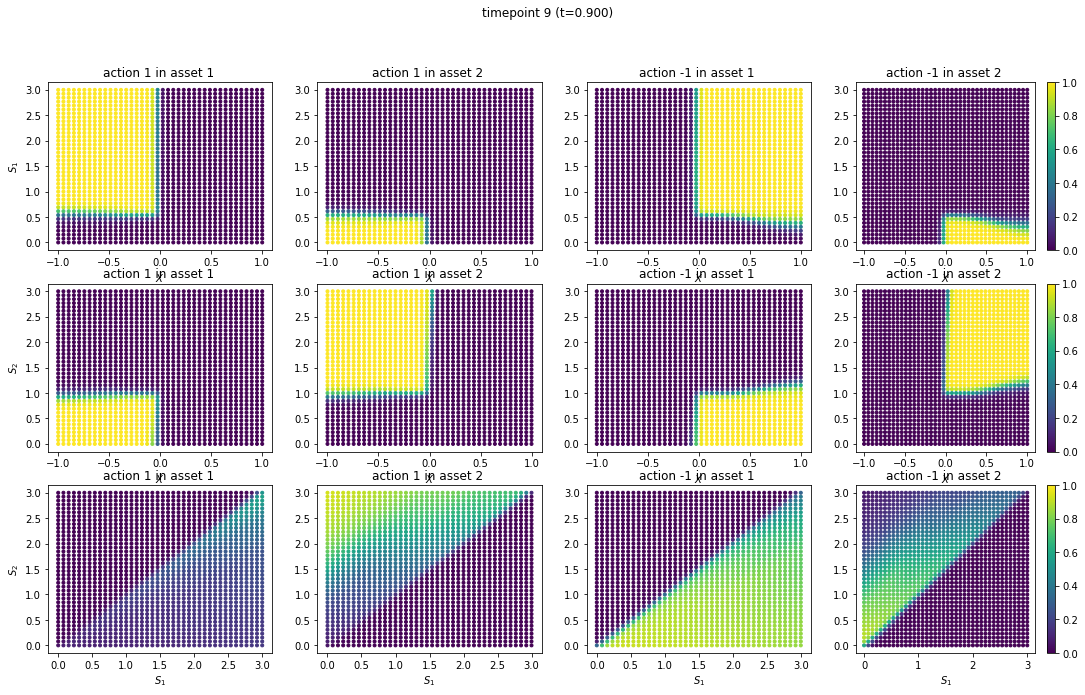

In [15]:
if d <= 2:
    pf.strategy_video(
        ntime=ntime,
        model=actor,
        start=ntime-1,
        end=ntime,
        d=d,
        resolution=40,
        x_value=x0,
        xmax=x0+1,
        xmin=x0-1,
        s1_value=1,
        s2_value=0.5,
        market_env=market_env,
    )

#### Actor Price & Value

In [16]:
factor = 1/(weights[0]+2*weights[1])

In [17]:
mf.calc_price(
    model=actor,
    asset_env=asset_env,
    x0=x0,
    s0=[1 for i in range(d)],
    npath=1000,
    poss_action=market_env.poss_action,
    ntime=ntime,
    r=interest,
    hardmax=False,
    market_env=market_env,
    weights=weights,
) 

0.09238676286117184

In [18]:
if d > 1:
    f_test = np.vectorize(
        lambda x, y: mf.calc_price(
            model=actor,
            asset_env=asset_env,
            x0=x0,
            s0=[x, y] + [1 for i in range(d - 2)],
            npath=1000,
            poss_action=market_env.poss_action,
            ntime=ntime,
            r=interest,
            hardmax=True,
            market_env=market_env,
            weights=weights,
        )
    )
else:
    f_test = np.vectorize(
        lambda x, y: mf.calc_price(
            model=actor,
            asset_env=asset_env,
            x0=x,
            s0=y,
            npath=1000,
            poss_action=market_env.poss_action,
            ntime=ntime,
            r=interest,
            hardmax=True,
            market_env=market_env,
            weights=weights,

        )
    )

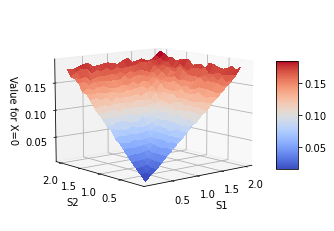

In [19]:
pf.plot_value(
    valuefun_vec=f_test,
    d=min(d, 2),
    smax=2,
    resolution=20,
    save=save,
    name=foldername + "actor_",
)

#### Critic Price & Value

In [20]:
initial_input = torch.tensor([[0, x0] + [1 for i in range(d)]], dtype=torch.float)

if additional_states is not None:
    initial_input = market_env.create_additional_states(initial_input)
    
(critic(initial_input).detach().numpy()+weights[1]*x0)*factor

array([[0.08902058]], dtype=float32)

In [21]:
def critic_fun(x,y):
    if d > 1:
        tensor_input =torch.tensor([[0, x0] + [x, y] + [1 for i in range(d - 2)]], dtype=torch.float)
        if additional_states is not None:
            tensor_input = market_env.create_additional_states(tensor_input)
        
        return((critic(tensor_input).detach().numpy()+weights[1]*x0)*factor)
    
    else:
        tensor_input =torch.tensor([[0] + [x, y]], dtype=torch.float)
        if additional_states is not None:
            tensor_input = market_env.create_additional_states(tensor_input)
        
        return((critic(tensor_input).detach().numpy()+weights[1]*x)*factor)

f_critic = np.vectorize(critic_fun)

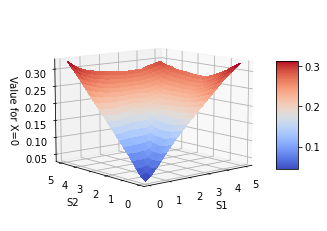

In [22]:
pf.plot_value(
    valuefun_vec=f_critic,
    d=min(d, 2),
    smax=5,
    resolution=20,
    save=save,
    name=foldername + "critic_",
)

#### trade with trained agent

In [23]:
if d < 3:
    # predict strategy

    npath2plot = 1000
    x0path = np.expand_dims(np.repeat(x0, npath2plot), axis=1)

    # create new market data or load standard data set

    W, S2plot = mf.create_paths(
        filepath="",
        npath=npath2plot,
        ntime=ntime,
        Sigma=Sigma,
        mu=mu,
        r=interest,
        s0=np.ones((npath2plot, d)),
        retBM=True,
        save_paths=False,
    )

    # determine approximated strategy (samples from NN-probability for the prediction)
    q, p = mf.strategies(
        npath=npath2plot,
        ntime=ntime,
        d=d,
        model=actor,
        S=S2plot,
        r=interest,
        poss_action=market_env.poss_action,
        hardmax=True,
        x0path=x0path,
        market_env=market_env,
    )

    print("finished predicting strategy\n")

    # portfolio value when trading with fitted strategy
    pv = mf.portfolio_value(q, S2plot, interest,x0path)

finished predicting strategy



/scratch/users/hwutte/Documents/Research/Passport_Option/PPPO/plot_functions.py:502: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


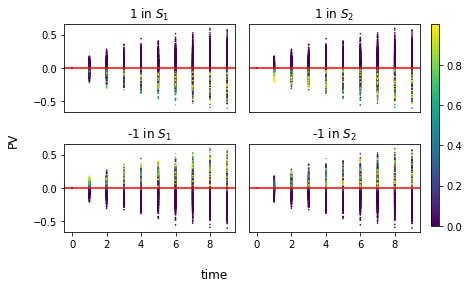

In [24]:
if d < 3:
    # Probability plots

    x = S2plot[:, :, 0]  # x-axis (however if timescale==True, x-axis will be time)
    timescale = True
    y = pv  # y-axis

    strat = p
    omegas = range(
        0,
        npath2plot,
        2 ** 0,
    )  # paths to plot

    pf.plot_probabilities(
        d=d,
        timerange=ntime,
        omegas=omegas,
        y=y,
        strategy_process=strat,
        poss_action=market_env.poss_action,
        x=x,
        timescale=timescale,
        xlabel="S",  # will be overwritten if timescale==True
        ylabel="PV",
        connectpaths=False,
    )  # set to true if paths should be connected by lines